# Importing Libraries and Loading Dataset

In [1]:
#%% Import Required Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import ConvexHull, QhullError


# Load the dataset

In [2]:
file_path = "data/Animation_Movies_After_Phase1.csv"
df = pd.read_csv(file_path)

# Display the first few rows of the dataset
print("Dataset Loaded Successfully!")
df.head()


Dataset Loaded Successfully!


id         title  vote_average  vote_count    status release_date  \
0  150540    Inside Out         7.922   19.208098  Released   2015-06-09   
1   14160            Up         7.949   19.208098  Released   2009-05-28   
2      12  Finding Nemo         7.824   19.208098  Released   2003-05-30   
3  354912          Coco         8.222   19.208098  Released   2017-10-27   
4   10681        WALL·E         8.078   19.208098  Released   2008-06-22   

        revenue    runtime  adult        budget  ... content_complexity  \
0  8.850803e+07  21.009978  False  1.954684e+07  ...                5.0   
1  8.850803e+07  21.009978  False  1.954684e+07  ...                4.0   
2  8.850803e+07  21.009978  False  1.954684e+07  ...                2.0   
3  8.850803e+07  21.009978  False  1.954684e+07  ...                6.0   
4  8.850803e+07  21.009978  False  1.954684e+07  ...                3.0   

  popularity_normalized runtime_normalized  vote_average_normalized  \
0              0.406107           0.212312                 1.572179   
1              0.406107           0.212312                 1.580282   
2              0.406107           0.212312                 1.542766   
3              0.406107           0.212312                 1.662216   
4              0.406107           0.212312                 1.618998   

  budget_normalized revenue_normalized vote_count_normalized Year_normalized  \
0          0.963383           0.970238              0.619616        0.925676   
1          0.963383           0.970238              0.619616        0.885135   
2          0.963383           0.970238              0.619616        0.844595   
3          0.963383           0.970238              0.619616        0.939189   
4          0.963383           0.970238              0.619616        0.878378   

   vote_count_bins release_year  
0     (18.6, 21.7]         2015  
1     (18.6, 21.7]         2009  
2     (18.6, 21.7]         2003  
3     (18.6, 21.7]         2017  
4     (18.6, 21.7]         2008  

[5 rows x 47 columns]

# Check for missing values

In [3]:
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values[missing_values > 0])

Missing values in each column:
processed_overview    62
dtype: int64


# Feature Selection: Genre and Content Similarity
# Features: genres, runtime_normalized, content_complexity


In [4]:
#%% Genre and Content Similarity
scaler = MinMaxScaler()
onehot_encoder = OneHotEncoder(sparse_output=False)

selected_features_genres = ['runtime_normalized', 'content_complexity']
encoded_genres = onehot_encoder.fit_transform(df[['genres']])
encoded_genres_df = pd.DataFrame(encoded_genres, columns=onehot_encoder.get_feature_names_out(['genres']))

# Combine numerical features with encoded genres
features_genres = pd.concat([df[selected_features_genres], encoded_genres_df], axis=1)
normalized_features_genres = scaler.fit_transform(features_genres)
print("Features for genre and content similarity normalized.")


Features for genre and content similarity normalized.


# Feature Selection: Commercial and Popularity Similarity
# Features: budget_normalized, revenue_normalized, ROI, popularity_normalized


In [5]:
#%% Commercial and Popularity Similarity
selected_features_commercial = ['budget_normalized', 'revenue_normalized', 'ROI', 'popularity_normalized']
features_commercial = df[selected_features_commercial]
normalized_features_commercial = scaler.fit_transform(features_commercial)
print("Features for commercial and popularity similarity normalized.")


Features for commercial and popularity similarity normalized.


# Feature Selection: General Combination
# Features: genres, popularity_normalized, vote_average_normalized, budget_normalized, runtime_normalized


In [6]:
#%% General Combination
selected_features_combined = ['popularity_normalized', 'vote_average_normalized', 'budget_normalized', 'runtime_normalized']
features_combined = pd.concat([df[selected_features_combined], encoded_genres_df], axis=1)
normalized_features_combined = scaler.fit_transform(features_combined)
print("Features for general combination similarity normalized.")


Features for general combination similarity normalized.


# Feature Selection: Temporal Analysis (Pure)
# Features: release_year, release_season


In [7]:
#%% Temporal Analysis
selected_features_time = ['release_year', 'release_season']
encoded_season = onehot_encoder.fit_transform(df[['release_season']])
encoded_season_df = pd.DataFrame(encoded_season, columns=onehot_encoder.get_feature_names_out(['release_season']))
features_time = pd.concat([df[['release_year']], encoded_season_df], axis=1)
normalized_features_time = scaler.fit_transform(features_time)
print("Features for temporal analysis normalized.")


Features for temporal analysis normalized.


# Feature Selection: Temporal and Content Analysis
# Features: release_year, release_season, genres, runtime_normalized


In [8]:
#%% Temporal and Content Analysis
selected_features_time_content = ['release_year', 'runtime_normalized']
features_time_content = pd.concat([df[selected_features_time_content], encoded_season_df, encoded_genres_df], axis=1)
normalized_features_time_content = scaler.fit_transform(features_time_content)
print("Features for temporal and content analysis normalized.")


Features for temporal and content analysis normalized.


# Feature Selection: Temporal and Commercial Analysis
# Features: release_year, release_season, budget_normalized, revenue_normalized, popularity_normalized


In [9]:
#%% Temporal and Commercial Analysis
selected_features_time_commercial = ['release_year', 'budget_normalized', 'revenue_normalized', 'popularity_normalized']
features_time_commercial = pd.concat([df[selected_features_time_commercial], encoded_season_df], axis=1)
normalized_features_time_commercial = scaler.fit_transform(features_time_commercial)
print("Features for temporal and commercial analysis normalized.")


Features for temporal and commercial analysis normalized.


In [10]:
#%% Define Feature Sets
feature_sets = {
    "Genre and Content Similarity": normalized_features_genres,
    # "Commercial and Popularity Similarity": normalized_features_commercial,
    "General Combination": normalized_features_combined,
    # "Temporal Analysis (Pure)": normalized_features_time,
    "Temporal and Content Analysis": normalized_features_time_content,
    "Temporal and Commercial Analysis": normalized_features_time_commercial,
}


# K-Means Clustering with Hyperparameter Tuning


In [11]:
#%% K-Means Tuning with Batch Processing
def kmeans_tuning_optimized_batch(normalized_features, max_k=8, batch_size=1000, feature_name=""):
    inertia = []
    silhouette_scores = []
    k_values = range(2, max_k + 1)

    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=min(10, normalized_features.shape[1]))
    reduced_features = pca.fit_transform(normalized_features)
    print(f"PCA applied. Reduced dimensions to {reduced_features.shape[1]}.")

    for k in k_values:
        print(f"Running K-Means for k={k}...")
        kmeans = KMeans(n_clusters=k, random_state=42, max_iter=100)
        kmeans.fit(reduced_features)
        inertia.append(kmeans.inertia_)
        
        # Get cluster labels
        labels = kmeans.labels_
        n_clusters = len(np.unique(labels))
        
        if n_clusters > 1:  # Silhouette Score is only valid if there are at least 2 clusters
            batch_silhouette_scores = []
            for i in range(0, len(reduced_features), batch_size):
                batch = reduced_features[i:i + batch_size]
                batch_labels = labels[i:i + batch_size]
                if len(np.unique(batch_labels)) > 1:  # Ensure batch has >1 unique labels
                    batch_silhouette_scores.extend(silhouette_samples(batch, batch_labels))
            if batch_silhouette_scores:
                avg_silhouette = np.mean(batch_silhouette_scores)
            else:
                avg_silhouette = None
            silhouette_scores.append(avg_silhouette)
        else:
            silhouette_scores.append(None)
            print(f"Silhouette Score cannot be calculated for k={k} as there is only 1 cluster.")

    # Automatically determine the best k using Silhouette Score
    valid_silhouette_scores = [(k, score) for k, score in zip(k_values, silhouette_scores) if score is not None]
    if valid_silhouette_scores:
        optimal_k = max(valid_silhouette_scores, key=lambda x: x[1])[0]
    else:
        optimal_k = 2  # Default to 2 if no valid silhouette scores are available
        print("No valid silhouette scores found. Defaulting optimal k to 2.")

    # Plot Elbow Method (Inertia)
    plt.figure(figsize=(8, 5))
    plt.plot(k_values, inertia, marker='o')
    plt.axvline(optimal_k, color='r', linestyle='--', label=f'Optimal k = {optimal_k}')
    plt.title(f"Elbow Method for Optimal K ({feature_name})")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Inertia")
    plt.legend()
    plt.grid()
    plt.show()
    
    # Plot Silhouette Scores
    plt.figure(figsize=(8, 5))
    plt.plot(k_values, [score if score is not None else 0 for score in silhouette_scores], marker='o')
    if valid_silhouette_scores:
        plt.axvline(optimal_k, color='r', linestyle='--', label=f'Optimal k = {optimal_k}')
    plt.title(f"Silhouette Scores for K ({feature_name})")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Silhouette Score")
    plt.legend()
    plt.grid()
    plt.show()
    
    return k_values, inertia, silhouette_scores, optimal_k


# DBSCAN Clustering with Optimal Parameters


In [12]:
#%% DBSCAN Tuning with Batch Processing and Separate Plots per Feature Set
def dbscan_tuning_batch(normalized_features, dbscan_params, batch_size=1000, feature_name=""):
    dbscan_results = []

    for params in dbscan_params:
        eps = params["eps"]
        min_samples = params["min_samples"]
        print(f"Testing DBSCAN with eps={eps}, min_samples={min_samples}...")

        # Apply DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(normalized_features)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)

        # Calculate silhouette score in batches if clusters exist
        if n_clusters > 1:
            batch_silhouette_scores = []
            for i in range(0, len(normalized_features), batch_size):
                batch = normalized_features[i:i + batch_size]
                batch_labels = labels[i:i + batch_size]
                if len(np.unique(batch_labels)) > 1:
                    batch_silhouette_scores.extend(silhouette_samples(batch, batch_labels))
            avg_silhouette = np.mean(batch_silhouette_scores)
        else:
            avg_silhouette = "Not applicable"

        # Append results
        dbscan_results.append({
            "eps": eps,
            "min_samples": min_samples,
            "n_clusters": n_clusters,
            "n_noise": n_noise,
            "silhouette_score": avg_silhouette,
        })

        print(f"DBSCAN with eps={eps}, min_samples={min_samples}:")
        print(f"  Number of clusters: {n_clusters}, Noise points: {n_noise}")
        print(f"  Silhouette Score: {avg_silhouette}")
    print(50 * '-')

    # Extract data for plots
    silhouette_scores = [
        result["silhouette_score"] for result in dbscan_results if result["silhouette_score"] != "Not applicable"
    ]
    n_clusters_list = [
        result["n_clusters"] for result in dbscan_results if result["silhouette_score"] != "Not applicable"
    ]
    eps_list = [
        result["eps"] for result in dbscan_results if result["silhouette_score"] != "Not applicable"
    ]
    min_samples_list = [
        result["min_samples"] for result in dbscan_results if result["silhouette_score"] != "Not applicable"
    ]

    # Plot Silhouette Scores Heatmap for the current feature set
    if silhouette_scores:
        plt.figure(figsize=(10, 6))
        plt.scatter(eps_list, min_samples_list, c=silhouette_scores, cmap='viridis', s=100)
        plt.colorbar(label="Silhouette Score")
        plt.title(f"DBSCAN Silhouette Scores ({feature_name})")
        plt.xlabel("Eps Values")
        plt.ylabel("Min Samples")
        plt.grid()
        plt.show()

    # Plot Number of Clusters Heatmap for the current feature set
    if n_clusters_list:
        plt.figure(figsize=(10, 6))
        plt.scatter(eps_list, min_samples_list, c=n_clusters_list, cmap='coolwarm', s=100)
        plt.colorbar(label="Number of Clusters")
        plt.title(f"DBSCAN Number of Clusters ({feature_name})")
        plt.xlabel("Eps Values")
        plt.ylabel("Min Samples")
        plt.grid()
        plt.show()

    return dbscan_results



Running K-Means tuning for: Genre and Content Similarity
PCA applied. Reduced dimensions to 10.
Running K-Means for k=2...
Running K-Means for k=3...
Running K-Means for k=4...
Running K-Means for k=5...
Running K-Means for k=6...
Running K-Means for k=7...
Running K-Means for k=8...


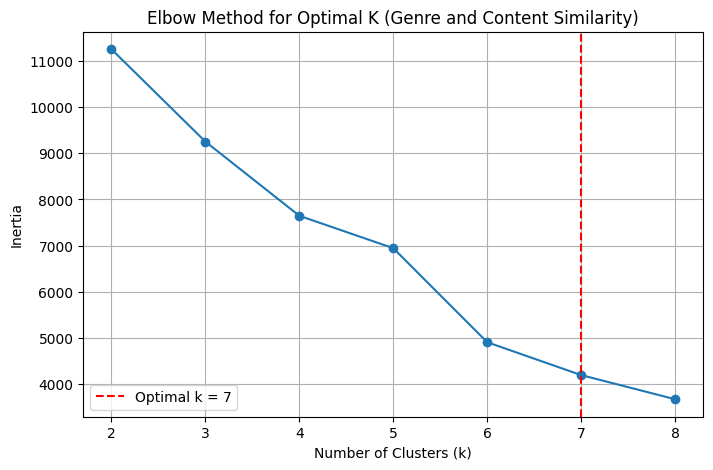

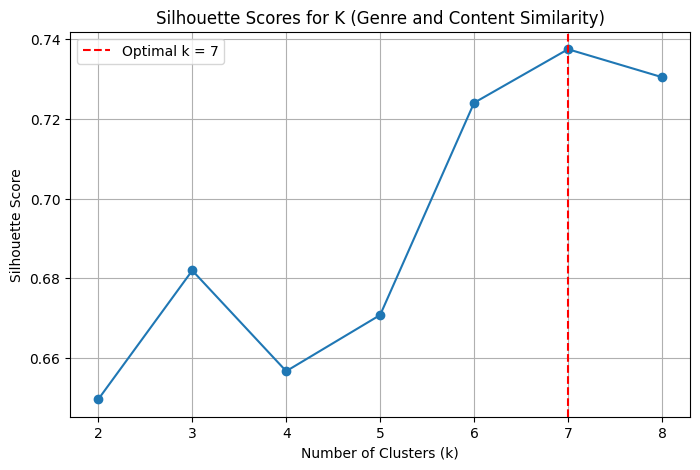


Running K-Means tuning for: General Combination
PCA applied. Reduced dimensions to 10.
Running K-Means for k=2...
Running K-Means for k=3...
Running K-Means for k=4...
Running K-Means for k=5...
Running K-Means for k=6...
Running K-Means for k=7...
Running K-Means for k=8...


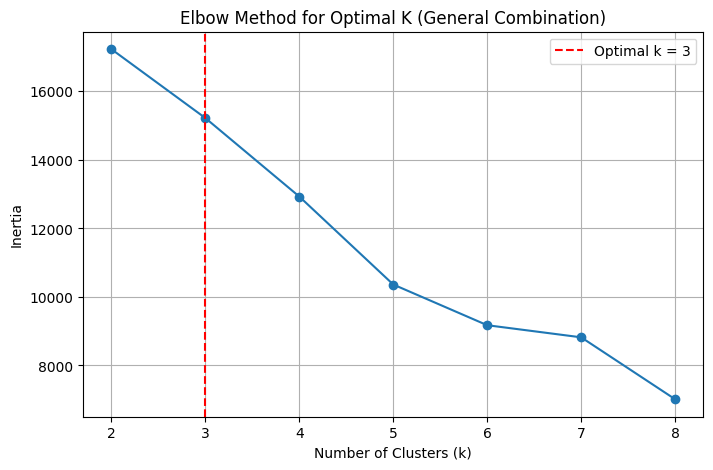

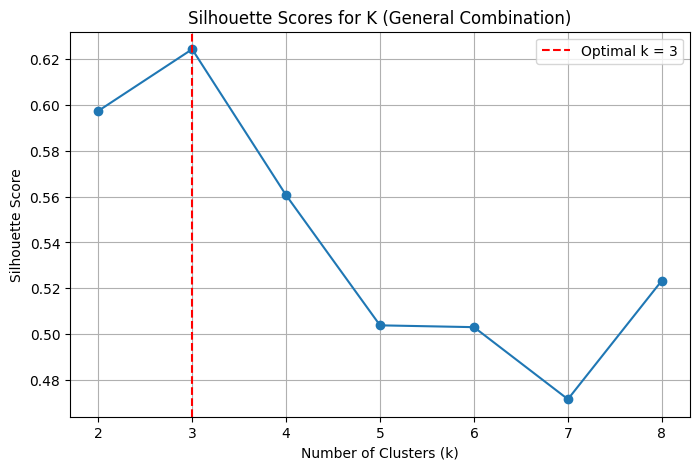


Running K-Means tuning for: Temporal and Content Analysis
PCA applied. Reduced dimensions to 10.
Running K-Means for k=2...
Running K-Means for k=3...
Running K-Means for k=4...
Running K-Means for k=5...
Running K-Means for k=6...
Running K-Means for k=7...
Running K-Means for k=8...


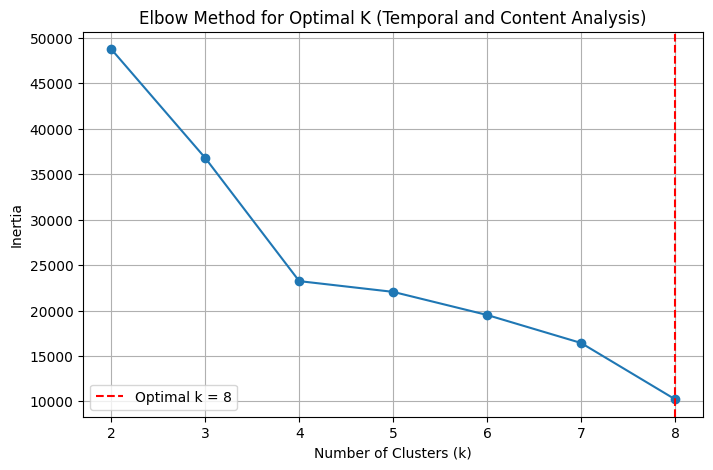

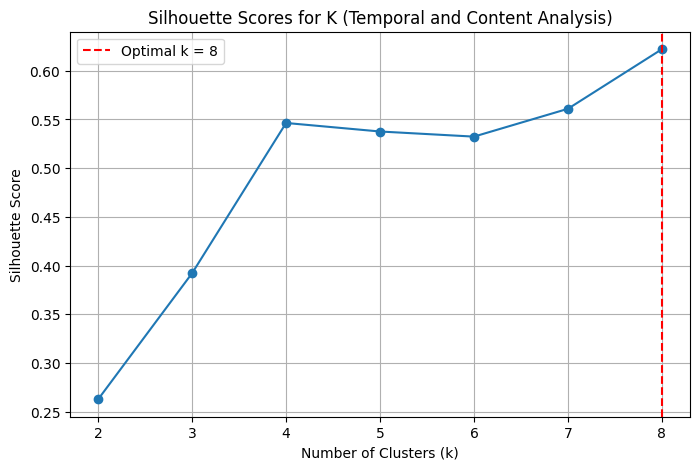


Running K-Means tuning for: Temporal and Commercial Analysis
PCA applied. Reduced dimensions to 8.
Running K-Means for k=2...
Running K-Means for k=3...
Running K-Means for k=4...
Running K-Means for k=5...
Running K-Means for k=6...
Running K-Means for k=7...
Running K-Means for k=8...


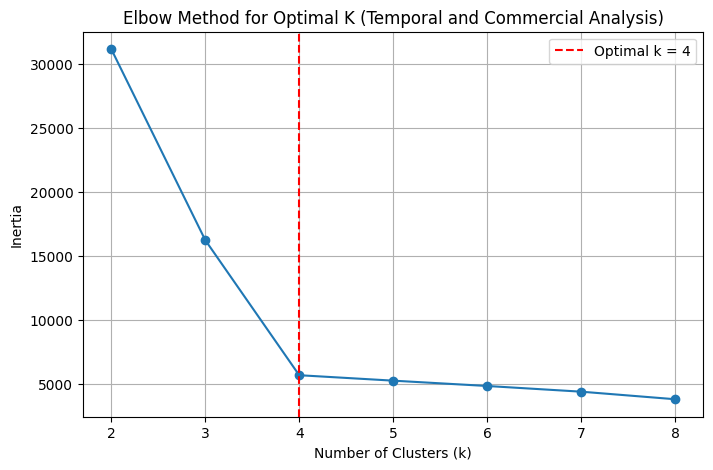

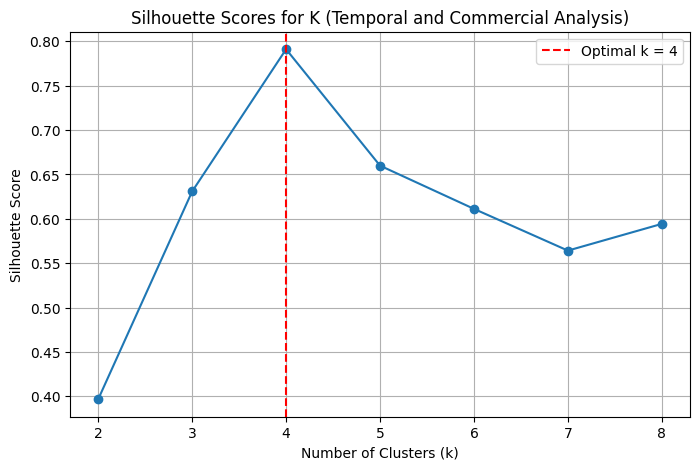

In [13]:
#%% Perform K-Means Clustering
kmeans_results = {}
for feature_name, feature_data in feature_sets.items():
    print(f"\nRunning K-Means tuning for: {feature_name}")
    k_values, inertia, silhouette_scores, optimal_k = kmeans_tuning_optimized_batch(
        feature_data, max_k=8, batch_size=1000, feature_name=feature_name
    )
    
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, max_iter=100)
    cluster_labels = kmeans.fit_predict(feature_data)
    df[f'kmeans_cluster_{feature_name.replace(" ", "_")}'] = cluster_labels
    
    kmeans_results[feature_name] = {
        "k_values": k_values,
        "inertia": inertia,
        "silhouette_scores": silhouette_scores,
        "optimal_k": optimal_k,
        "cluster_labels": cluster_labels,
    }


Generating K-Distance Graph for: Genre and Content Similarity with k=6


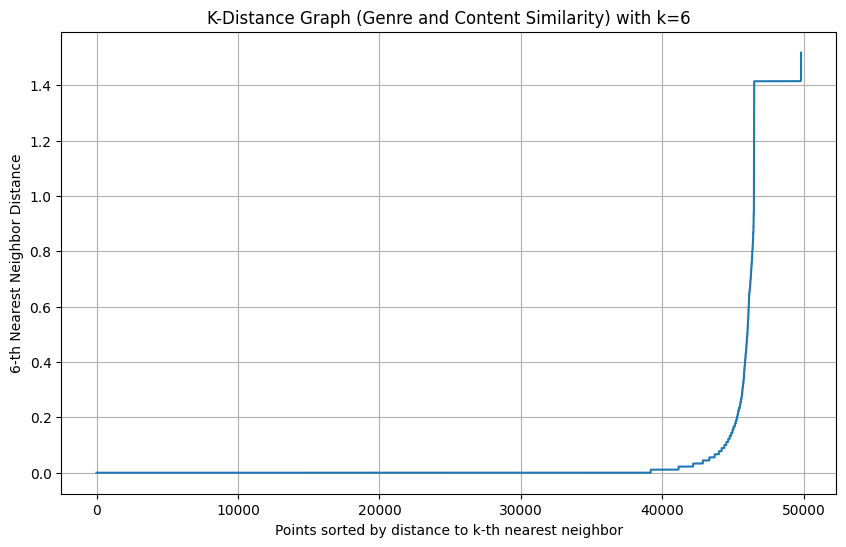

Generating K-Distance Graph for: General Combination with k=2


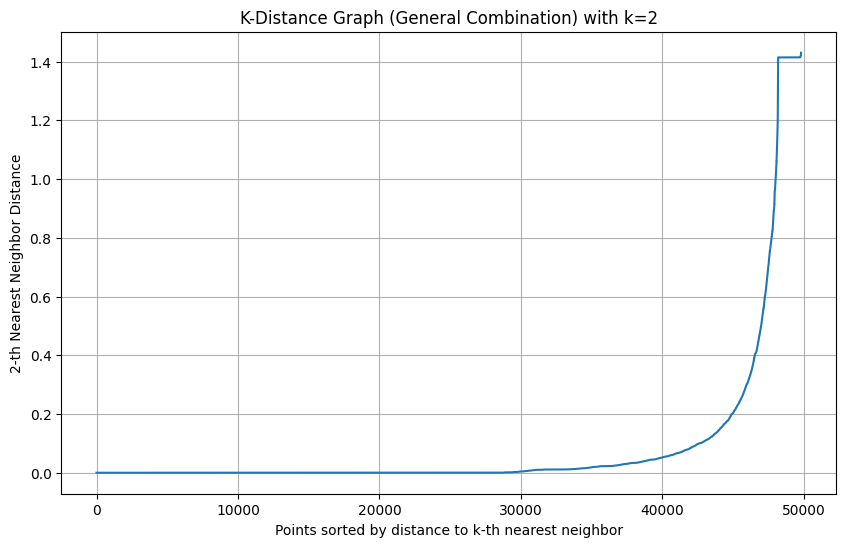

Generating K-Distance Graph for: Temporal and Content Analysis with k=7


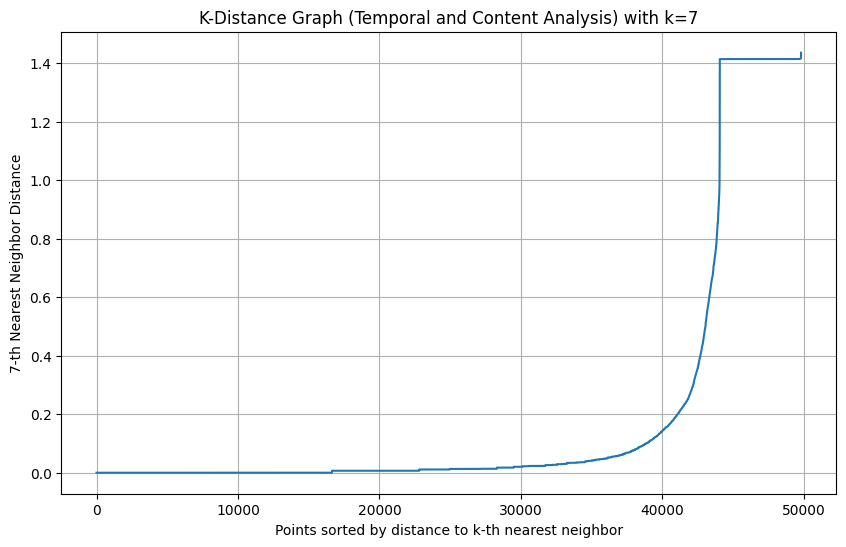

Generating K-Distance Graph for: Temporal and Commercial Analysis with k=3


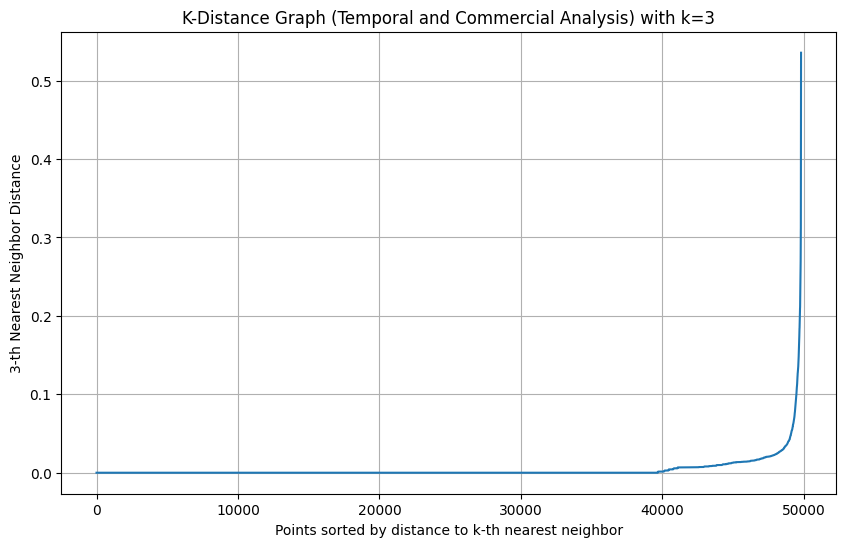

In [14]:
# Loop through each feature set and dynamically adjust k based on K-Means optimal_k
for feature_name, feature_data in feature_sets.items():
    # Extract the optimal_k from K-Means results
    optimal_k = kmeans_results[feature_name]["optimal_k"]  # Optimal number of clusters
    
    # Set k as optimal_k - 1 for DBSCAN (DBSCAN usually uses min_samples - 1)
    k = max(1, optimal_k - 1)  # Ensure k is at least 1
    
    print(f"Generating K-Distance Graph for: {feature_name} with k={k}")
    
    # Fit Nearest Neighbors
    nearest_neighbors = NearestNeighbors(n_neighbors=k)
    nearest_neighbors.fit(feature_data)
    distances, indices = nearest_neighbors.kneighbors(feature_data)
    
    # Sort distances for plotting
    distances = np.sort(distances[:, -1])  # Sort the k-th nearest distances
    
    # Plot the K-Distance Graph
    plt.figure(figsize=(10, 6))
    plt.plot(distances)
    plt.title(f"K-Distance Graph ({feature_name}) with k={k}")
    plt.xlabel("Points sorted by distance to k-th nearest neighbor")
    plt.ylabel(f"{k}-th Nearest Neighbor Distance")
    plt.grid()
    plt.show()


In [15]:
#%% Perform DBSCAN Clustering for Each Feature Set
dbscan_params = {
    "Genre and Content Similarity": [
        {"eps": 0.3, "min_samples": 10},
        {"eps": 0.4, "min_samples": 20},
        {"eps": 0.5, "min_samples": 30},
    ],
    "Commercial and Popularity Similarity": [
        {"eps": 0.3, "min_samples": 20},
        {"eps": 0.5, "min_samples": 30},
        {"eps": 0.7, "min_samples": 50},
    ],
    "General Combination": [
        {"eps": 0.8, "min_samples": 50},
        {"eps": 1.0, "min_samples": 100},
        {"eps": 1.2, "min_samples": 150},
    ],
    "Temporal Analysis (Pure)": [
        {"eps": 0.03, "min_samples": 5},
        {"eps": 0.05, "min_samples": 10},
        {"eps": 0.07, "min_samples": 15},
    ],
    "Temporal and Content Analysis": [
        {"eps": 0.5, "min_samples": 20},
        {"eps": 0.6, "min_samples": 40},
        {"eps": 0.7, "min_samples": 60},
    ],
    "Temporal and Commercial Analysis": [
        {"eps": 0.2, "min_samples": 10},
        {"eps": 0.3, "min_samples": 15},
        {"eps": 0.4, "min_samples": 20},
    ],
}

In [16]:
#%% Perform DBSCAN Clustering for Each Feature Set with Multiple Parameter Combinations
dbscan_results_summary = {}

for feature_name, feature_data in feature_sets.items():
    print(f"\nRunning DBSCAN tuning for: {feature_name}")
    
    dbscan_results = []
    for params in dbscan_params[feature_name]:
        eps = params["eps"]
        min_samples = params["min_samples"]
        print(f"Testing DBSCAN with eps={eps}, min_samples={min_samples}...")
        
        # Apply DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(feature_data)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)

        # Calculate silhouette score if clusters exist
        if n_clusters > 1:
            silhouette = np.mean(silhouette_samples(feature_data, labels))
        else:
            silhouette = "Not applicable"

        # Append results
        dbscan_results.append({
            "eps": eps,
            "min_samples": min_samples,
            "n_clusters": n_clusters,
            "n_noise": n_noise,
            "silhouette_score": silhouette,
        })

        print(f"DBSCAN with eps={eps}, min_samples={min_samples}:")
        print(f"  Number of clusters: {n_clusters}, Noise points: {n_noise}")
        print(f"  Silhouette Score: {silhouette}")

    # Analyze the best parameters
    best_dbscan = max(
        (r for r in dbscan_results if r["silhouette_score"] != "Not applicable"),
        key=lambda x: x["silhouette_score"],
        default=None,
    )
    
    if best_dbscan:
        print(f"Best DBSCAN for {feature_name}:")
        print(f"  eps={best_dbscan['eps']}, min_samples={best_dbscan['min_samples']}")
        print(f"  Number of clusters: {best_dbscan['n_clusters']}, Noise points: {best_dbscan['n_noise']}")
        print(f"  Silhouette Score: {best_dbscan['silhouette_score']}")
        
        # Apply DBSCAN with best parameters
        dbscan = DBSCAN(eps=best_dbscan['eps'], min_samples=best_dbscan['min_samples'])
        labels = dbscan.fit_predict(feature_data)
        df[f'dbscan_cluster_{feature_name.replace(" ", "_")}'] = labels
        
        # Save results
        dbscan_results_summary[feature_name] = best_dbscan
    else:
        print(f"No suitable DBSCAN clustering found for {feature_name}.")



Running DBSCAN tuning for: Genre and Content Similarity
Testing DBSCAN with eps=0.3, min_samples=10...
DBSCAN with eps=0.3, min_samples=10:
  Number of clusters: 185, Noise points: 4809
  Silhouette Score: 0.7893838388228958
Testing DBSCAN with eps=0.4, min_samples=20...
DBSCAN with eps=0.4, min_samples=20:
  Number of clusters: 103, Noise points: 5875
  Silhouette Score: 0.7724752726156155
Testing DBSCAN with eps=0.5, min_samples=30...
DBSCAN with eps=0.5, min_samples=30:
  Number of clusters: 79, Noise points: 6361
  Silhouette Score: 0.765109232434878
Best DBSCAN for Genre and Content Similarity:
  eps=0.3, min_samples=10
  Number of clusters: 185, Noise points: 4809
  Silhouette Score: 0.7893838388228958

Running DBSCAN tuning for: General Combination
Testing DBSCAN with eps=0.8, min_samples=50...
DBSCAN with eps=0.8, min_samples=50:
  Number of clusters: 53, Noise points: 7415
  Silhouette Score: 0.5712810276688475
Testing DBSCAN with eps=1.0, min_samples=100...
DBSCAN with eps=1

In [17]:
#%% Report Best Results for Clustering
print("--- Final Clustering Results ---\n")

# KMeans Results Summary
print("--- KMeans Results ---")
for feature_name, results in kmeans_results.items():
    print(f"Feature Set: {feature_name}")
    print(f"  Optimal k: {results['optimal_k']}")
    print(f"  Best Silhouette Score: {max(results['silhouette_scores'])}")
    cluster_distribution = pd.Series(results["cluster_labels"]).value_counts().to_dict()
    print(f"  Cluster Distribution: {cluster_distribution}\n")

# DBSCAN Results Summary
print("--- DBSCAN Results ---")
for feature_name, results in dbscan_results_summary.items():
    print(f"Feature Set: {feature_name}")
    print(f"  Best eps: {results['eps']}")
    print(f"  Best min_samples: {results['min_samples']}")
    print(f"  Number of clusters: {results['n_clusters']}")
    print(f"  Noise points: {results['n_noise']}")
    print(f"  Best Silhouette Score: {results['silhouette_score']}\n")


--- Final Clustering Results ---

--- KMeans Results ---
Feature Set: Genre and Content Similarity
  Optimal k: 7
  Best Silhouette Score: 0.7374584569476987
  Cluster Distribution: {1: 27258, 6: 12175, 2: 4258, 0: 2422, 5: 2154, 4: 812, 3: 729}

Feature Set: General Combination
  Optimal k: 3
  Best Silhouette Score: 0.6242287870612618
  Cluster Distribution: {1: 27252, 2: 12538, 0: 10018}

Feature Set: Temporal and Content Analysis
  Optimal k: 8
  Best Silhouette Score: 0.6221271350836207
  Cluster Distribution: {1: 11123, 7: 7375, 3: 5845, 2: 5799, 6: 5164, 5: 5126, 0: 4886, 4: 4490}

Feature Set: Temporal and Commercial Analysis
  Optimal k: 4
  Best Silhouette Score: 0.7911275260123095
  Cluster Distribution: {1: 18498, 2: 11644, 0: 10012, 3: 9654}

--- DBSCAN Results ---
Feature Set: Genre and Content Similarity
  Best eps: 0.3
  Best min_samples: 10
  Number of clusters: 185
  Noise points: 4809
  Best Silhouette Score: 0.7893838388228958

Feature Set: General Combination
  Bes

In [18]:
#%% Analyze Cluster Patterns
print("--- Cluster Patterns Analysis ---\n")

# KMeans Cluster Analysis
print("--- KMeans Patterns ---")
for feature_name, results in kmeans_results.items():
    print(f"\nFeature Set: {feature_name}")
    cluster_labels = df[f'kmeans_cluster_{feature_name.replace(" ", "_")}']
    for cluster in np.unique(cluster_labels):
        print(f"Cluster {cluster}:")
        cluster_data = df[cluster_labels == cluster]
        print(cluster_data.describe())  # Statistical summary of each cluster

# DBSCAN Cluster Analysis
print("--- DBSCAN Patterns ---")
for feature_name, results in dbscan_results_summary.items():
    print(f"\nFeature Set: {feature_name}")
    cluster_labels = df[f'dbscan_cluster_{feature_name.replace(" ", "_")}']
    for cluster in np.unique(cluster_labels):
        if cluster == -1:  # Skip noise points
            print(f"Noise Points: {len(df[cluster_labels == -1])}")
            continue
        print(f"Cluster {cluster}:")
        cluster_data = df[cluster_labels == cluster]
        print(cluster_data.describe())  # Statistical summary of each cluster


--- Cluster Patterns Analysis ---

--- KMeans Patterns ---

Feature Set: Genre and Content Similarity
Cluster 0:
                 id  vote_average   vote_count       revenue      runtime  \
count  2.422000e+03   2422.000000  2422.000000  2.422000e+03  2422.000000   
mean   5.269353e+05      3.580382     5.182134  9.567655e+04    11.830945   
std    3.716442e+05      3.302106     7.754104  2.283445e+06    17.381150   
min    2.751000e+03      0.000000     0.000000  0.000000e+00     0.000000   
25%    2.019878e+05      0.000000     0.000000  0.000000e+00     4.000000   
50%    4.723195e+05      5.000000     1.000000  0.000000e+00     7.000000   
75%    8.348890e+05      6.500000     7.000000  0.000000e+00     9.000000   
max    1.237982e+06     10.000000    31.000000  8.313760e+07    90.000000   

             budget   popularity         Year  original_language_encoded  \
count  2.422000e+03  2422.000000  2422.000000                2422.000000   
mean   2.574964e+04     0.743990  1982.25

Visualizing KMeans Clusters for Feature Set: Genre and Content Similarity


C:\Users\Pooria\AppData\Local\Temp\ipykernel_13284\437241759.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20", len(unique_labels))  # Improved colormap


ConvexHull error for cluster 0, skipping hull drawing.
ConvexHull error for cluster 1, skipping hull drawing.
ConvexHull error for cluster 3, skipping hull drawing.
ConvexHull error for cluster 4, skipping hull drawing.


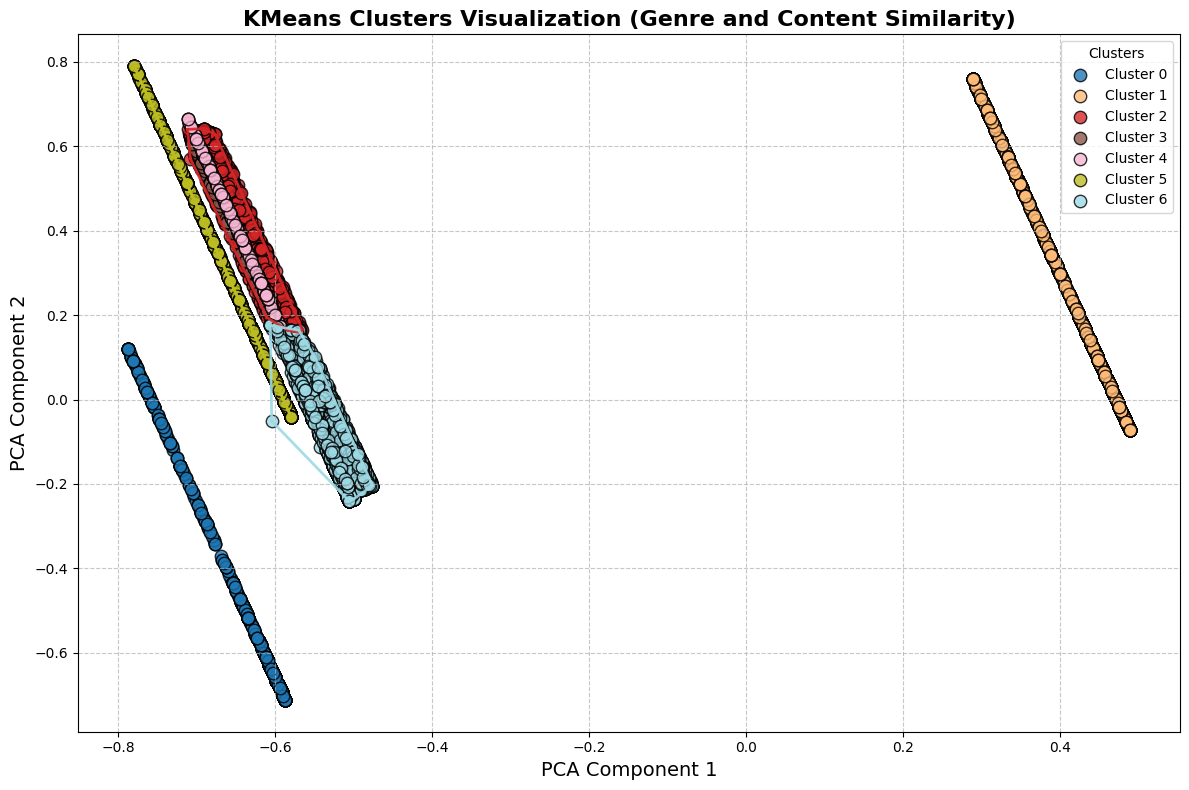

Visualizing KMeans Clusters for Feature Set: General Combination


C:\Users\Pooria\AppData\Local\Temp\ipykernel_13284\437241759.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20", len(unique_labels))  # Improved colormap


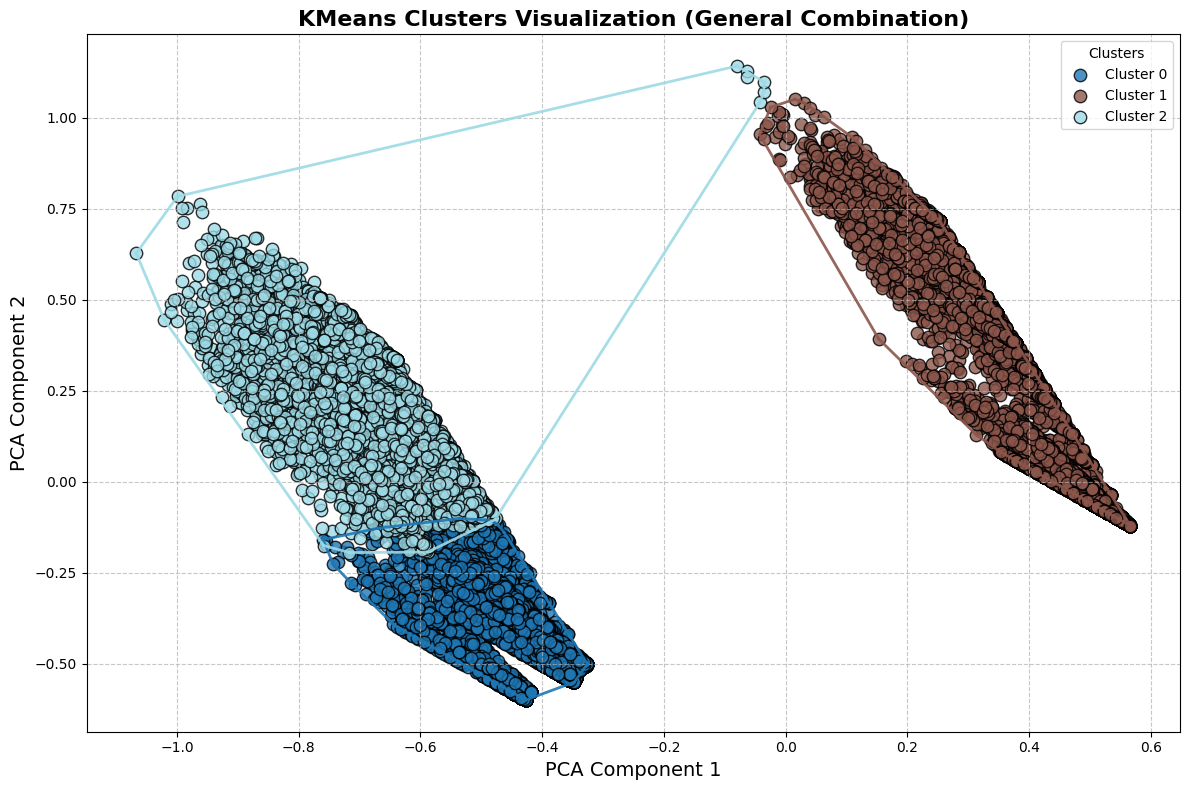

Visualizing KMeans Clusters for Feature Set: Temporal and Content Analysis


C:\Users\Pooria\AppData\Local\Temp\ipykernel_13284\437241759.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20", len(unique_labels))  # Improved colormap


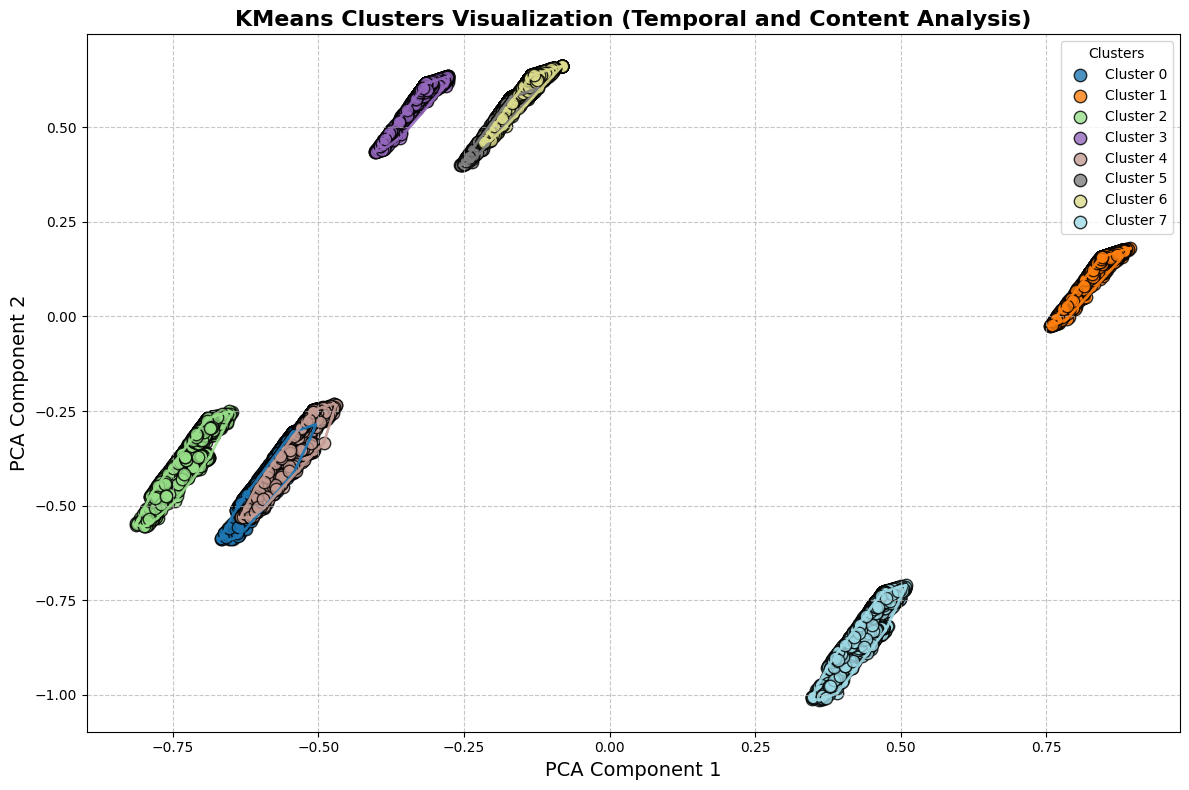

Visualizing KMeans Clusters for Feature Set: Temporal and Commercial Analysis


C:\Users\Pooria\AppData\Local\Temp\ipykernel_13284\437241759.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20", len(unique_labels))  # Improved colormap


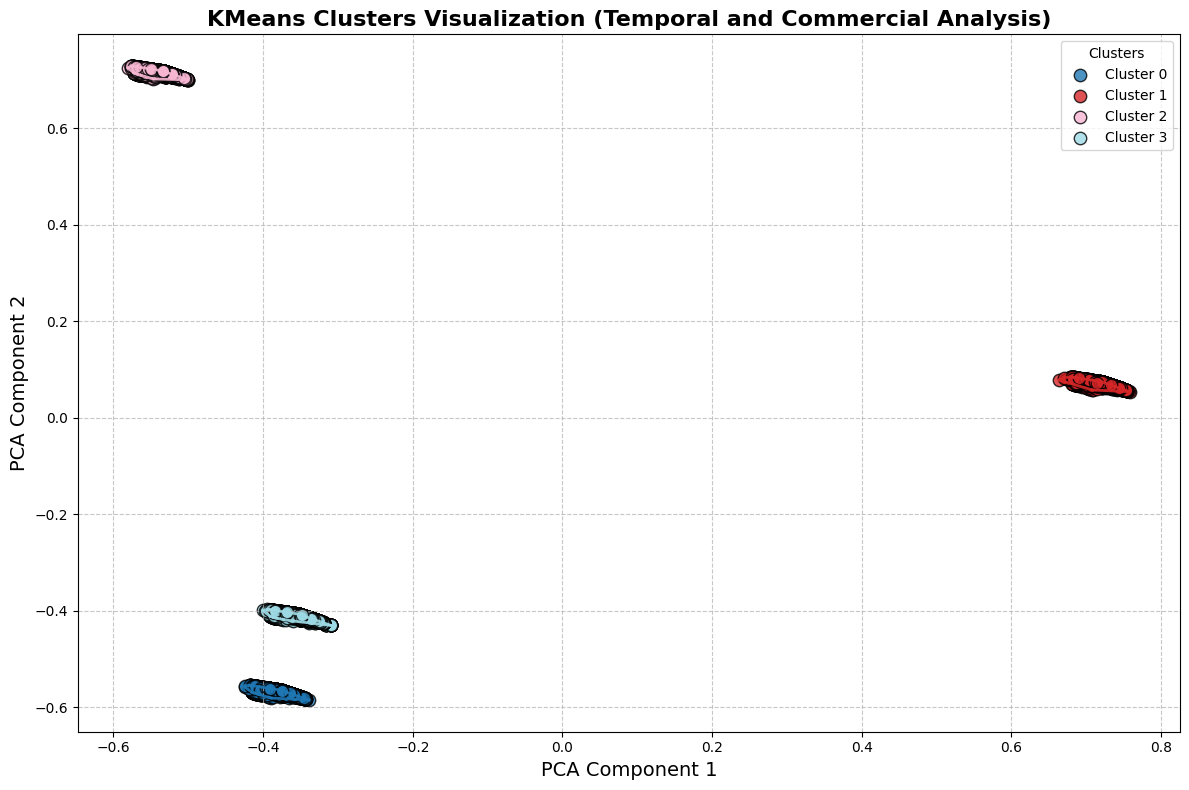

Visualizing DBSCAN Clusters for Feature Set: Genre and Content Similarity


C:\Users\Pooria\AppData\Local\Temp\ipykernel_13284\437241759.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20", len(unique_labels))  # Improved colormap


ConvexHull error for cluster 0, skipping hull drawing.
ConvexHull error for cluster 1, skipping hull drawing.
ConvexHull error for cluster 2, skipping hull drawing.
ConvexHull error for cluster 3, skipping hull drawing.
ConvexHull error for cluster 4, skipping hull drawing.
ConvexHull error for cluster 5, skipping hull drawing.
ConvexHull error for cluster 6, skipping hull drawing.
ConvexHull error for cluster 7, skipping hull drawing.
ConvexHull error for cluster 8, skipping hull drawing.
ConvexHull error for cluster 9, skipping hull drawing.
ConvexHull error for cluster 10, skipping hull drawing.
ConvexHull error for cluster 11, skipping hull drawing.
ConvexHull error for cluster 12, skipping hull drawing.
ConvexHull error for cluster 13, skipping hull drawing.
ConvexHull error for cluster 14, skipping hull drawing.
ConvexHull error for cluster 15, skipping hull drawing.
ConvexHull error for cluster 16, skipping hull drawing.
ConvexHull error for cluster 17, skipping hull drawing.
Co

C:\Users\Pooria\AppData\Local\Temp\ipykernel_13284\437241759.py:63: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


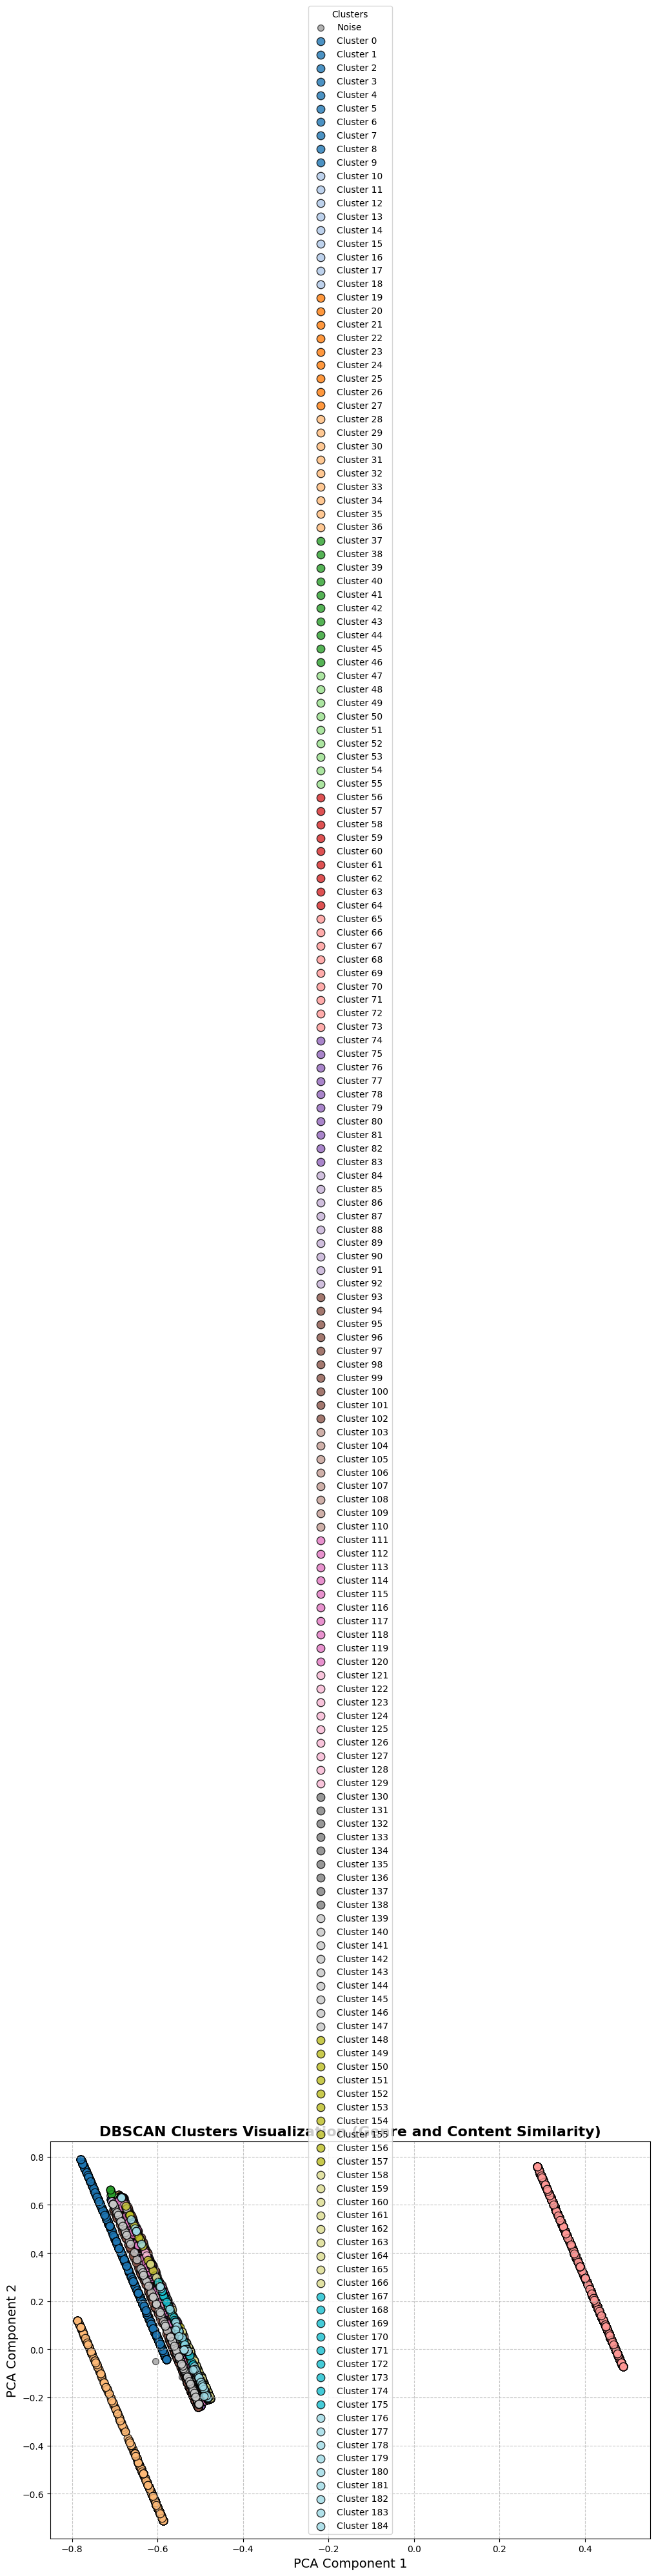

Visualizing DBSCAN Clusters for Feature Set: General Combination


C:\Users\Pooria\AppData\Local\Temp\ipykernel_13284\437241759.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20", len(unique_labels))  # Improved colormap


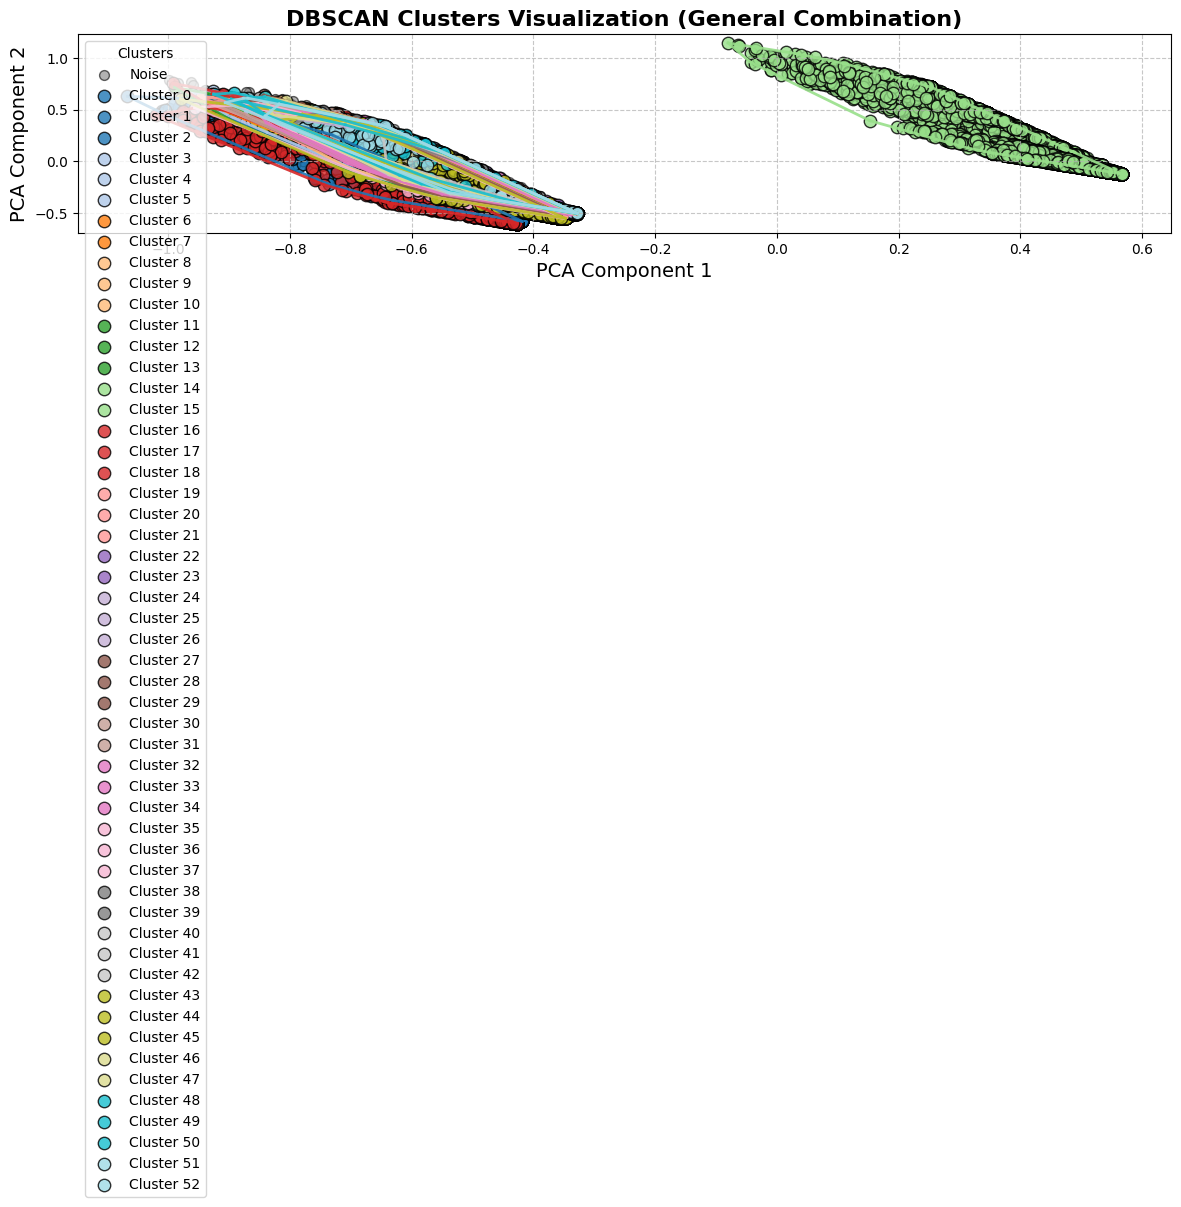

Visualizing DBSCAN Clusters for Feature Set: Temporal and Content Analysis


C:\Users\Pooria\AppData\Local\Temp\ipykernel_13284\437241759.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20", len(unique_labels))  # Improved colormap
C:\Users\Pooria\AppData\Local\Temp\ipykernel_13284\437241759.py:63: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


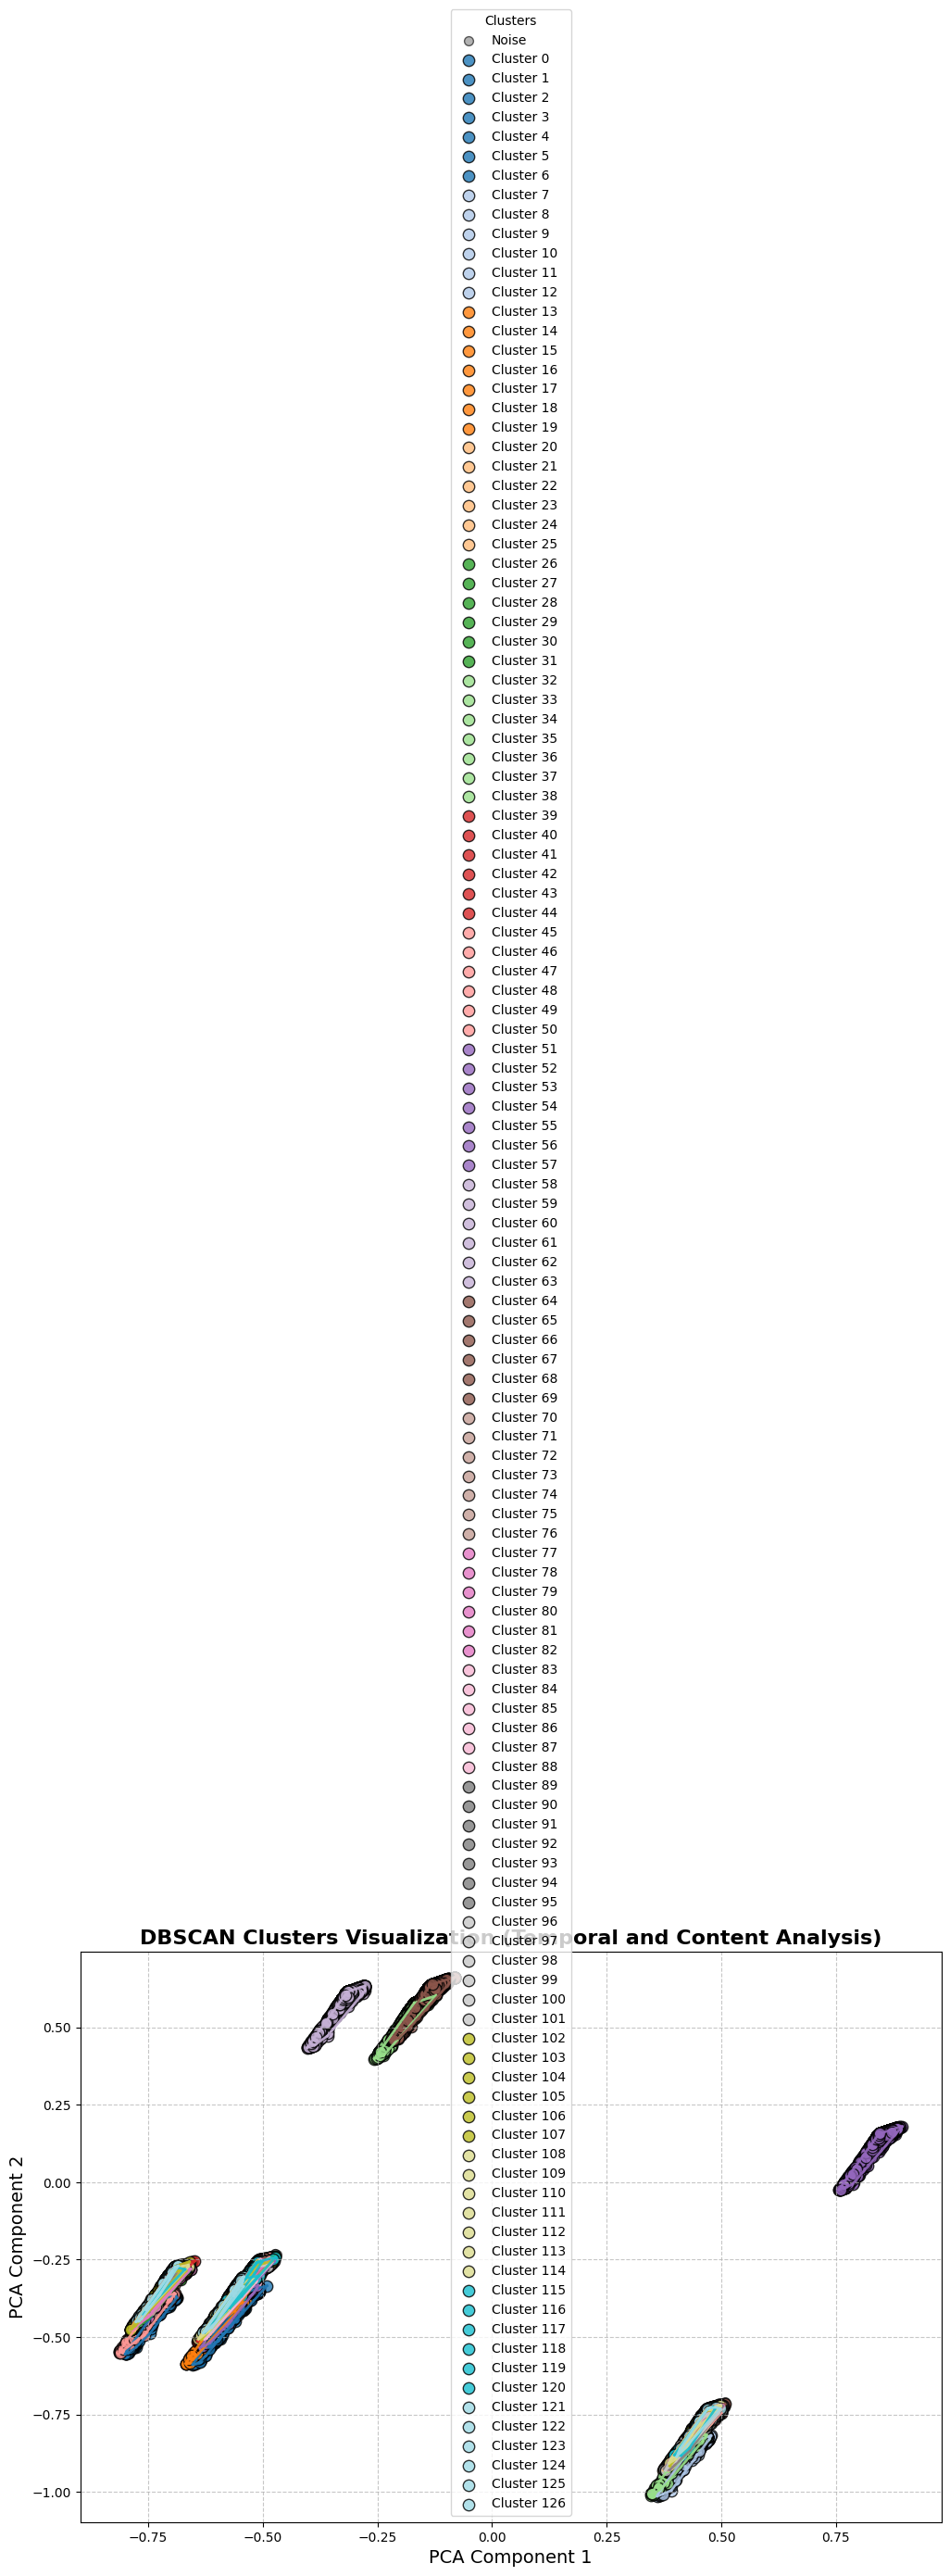

Visualizing DBSCAN Clusters for Feature Set: Temporal and Commercial Analysis


C:\Users\Pooria\AppData\Local\Temp\ipykernel_13284\437241759.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20", len(unique_labels))  # Improved colormap


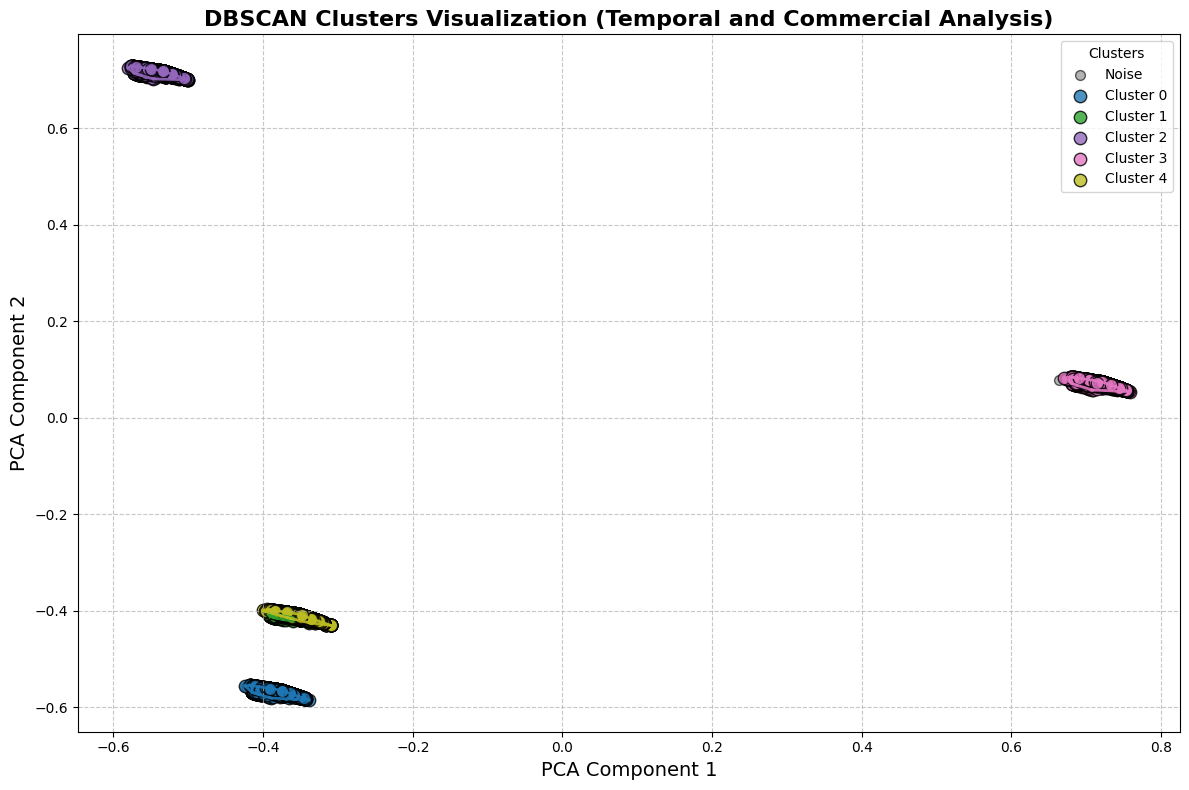

In [19]:
#%% Enhanced Visualization of Clusters with Improved Design

def plot_clusters_with_hulls_improved(data, labels, feature_name, algorithm_name):
    # Reduce data to 2D using PCA
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data)

    # Create a scatter plot
    plt.figure(figsize=(12, 8))
    unique_labels = np.unique(labels)
    colors = plt.cm.get_cmap("tab20", len(unique_labels))  # Improved colormap

    for label in unique_labels:
        if label == -1:
            # Noise points
            plt.scatter(
                reduced_data[labels == label, 0],
                reduced_data[labels == label, 1],
                c="gray",
                s=50,
                label="Noise",
                alpha=0.6,
                edgecolor="k",
            )
        else:
            # Cluster points
            cluster_points = reduced_data[labels == label]
            plt.scatter(
                cluster_points[:, 0],
                cluster_points[:, 1],
                color=colors(label / len(unique_labels)),
                s=80,
                label=f"Cluster {label}",
                alpha=0.8,
                edgecolor="k",
            )

            # Draw convex hull around the cluster (only if enough points exist)
            if len(cluster_points) > 3:  # ConvexHull needs at least 4 points
                try:
                    hull = ConvexHull(cluster_points)
                    for simplex in hull.simplices:
                        plt.plot(
                            cluster_points[simplex, 0],
                            cluster_points[simplex, 1],
                            c=colors(label / len(unique_labels)),
                            lw=2,
                            alpha=0.9,
                        )
                except QhullError:
                    print(f"ConvexHull error for cluster {label}, skipping hull drawing.")

    # Enhance plot aesthetics
    plt.title(
        f"{algorithm_name} Clusters Visualization ({feature_name})",
        fontsize=16,
        fontweight="bold",
    )
    plt.xlabel("PCA Component 1", fontsize=14)
    plt.ylabel("PCA Component 2", fontsize=14)
    plt.legend(title="Clusters", loc="best", fontsize=10)
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


# Visualize KMeans Clusters
for feature_name, results in kmeans_results.items():
    print(f"Visualizing KMeans Clusters for Feature Set: {feature_name}")
    cluster_labels = df[f'kmeans_cluster_{feature_name.replace(" ", "_")}']
    plot_clusters_with_hulls_improved(
        data=feature_sets[feature_name],
        labels=cluster_labels,
        feature_name=feature_name,
        algorithm_name="KMeans",
    )

# Visualize DBSCAN Clusters
for feature_name, results in dbscan_results_summary.items():
    print(f"Visualizing DBSCAN Clusters for Feature Set: {feature_name}")
    cluster_labels = df[f'dbscan_cluster_{feature_name.replace(" ", "_")}']
    plot_clusters_with_hulls_improved(
        data=feature_sets[feature_name],
        labels=cluster_labels,
        feature_name=feature_name,
        algorithm_name="DBSCAN",
    )
